In [313]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_error
from statsmodels.api import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan

# 分类数据建模1

## 概述

本 Jupyter Notebook 主要探索如何将诸如性别等分类变量纳入线性回归模型，以及如何有效地可视化这些影响。为此，我们生成一个包含 500 行的合成数据集，其中包含数值和分类特征，如年龄和性别，以及一个连续目标变量——收入。基于该数据集，我们将进行线性回归，以预测收入（基于年龄和性别）。

完成本节后，您将能够：

- **理解回归中的分类变量**：了解如何使用诸如独热编码（one-hot encoding）等技术将分类变量纳入回归模型。
- **影响分析**：理解不同类别如何影响目标变量，并通过可视化解读这些影响。

## 生成数据

我们将使用以下函数生成合成数据，从而为男性和女性群体生成不同的收入值。这样可以帮助我们在回归模型中更好地分析性别对收入的影响。

In [314]:
def generate_data(N):
    """
    Generate a DataFrame with synthetic data.

    Parameters
    ----------
    N : int
        The number of rows to generate in the DataFrame.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing `N` rows with columns for Age, Gender, and Income.

    Notes
    -----
    - Ages are randomly generated integers between 20 and 60.
    - Genders are randomly assigned as either 'Male' or 'Female'.
    - Income is calculated as a base value plus an amount that depends on
      age and gender, with some random noise added for realism.
    - Gender is encoded such that 'Male' has an additional income boost.
    """
    np.random.seed(0)  # For reproducibility
    ages = np.random.randint(20, 60, size=N)
    genders = np.random.choice(["Male", "Female"], size=N)
    incomes = (
        30000 + ages * 1000 + (genders == "Male") * 5000 + np.random.normal(0, 5000, N)
    )

    df = pd.DataFrame({"Age": ages, "Gender": genders, "Income": incomes})
    return df

In [315]:
N = 500
data = generate_data(N)

## 数据可视化

我们将从绘制数据的散点图开始，以初步观察年龄、性别和收入之间的关系。这将帮助我们更直观地理解不同类别对收入的影响。

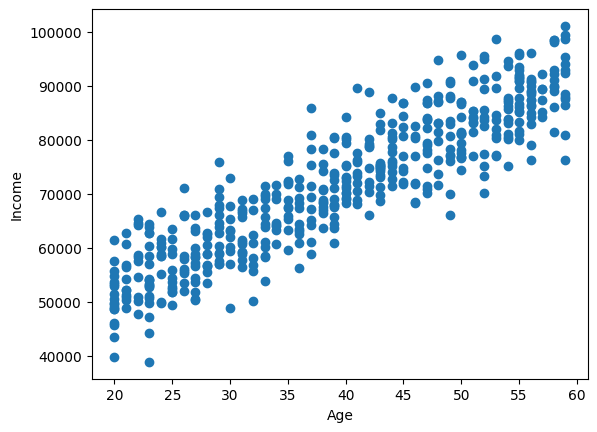

In [316]:
plt.scatter(data["Age"], data["Income"])
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

确实，我们可以立即识别出线性模型适合该数据。这一点显而易见，因为我们使用线性模型生成了这些数据！这样做的目的是更清晰地展示线性回归在包含分类变量的数据中的效果。

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     2181.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          4.24e-184
Time:                        01:21:32   Log-Likelihood:                -5031.1
No. Observations:                 500   AIC:                         1.007e+04
Df Residuals:                     498   BIC:                         1.007e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.19e+04    890.111     35.842      0.0

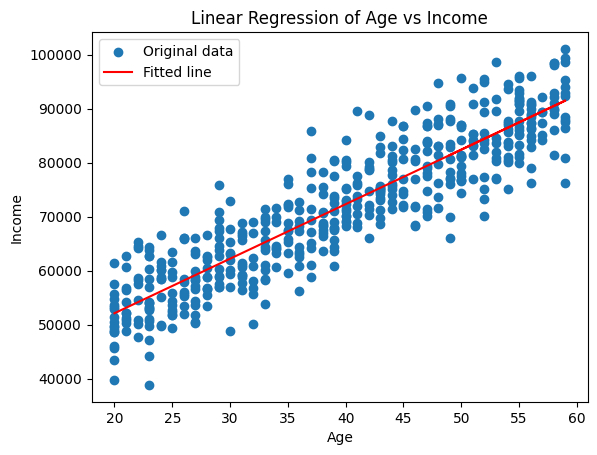

In [317]:
x = data["Age"].values.reshape(-1, 1)
y = data["Income"].values

x_with_intercept = add_constant(x)
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat = results.params
income_pred = results.predict(x_with_intercept)

print(rf"$\beta_1$ (Age): {beta_1_hat}")
print(f"$\beta_0$: {beta_0_hat}")

plt.scatter(x, y, label="Original data")
plt.plot(x, income_pred, color="red", label="Fitted line")
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Linear Regression of Age vs Income")
plt.legend()
plt.show()

We will now investigate for evidence to adjust fo接下来我们将深入分析，以找到调整 `Gender` 因素的依据。

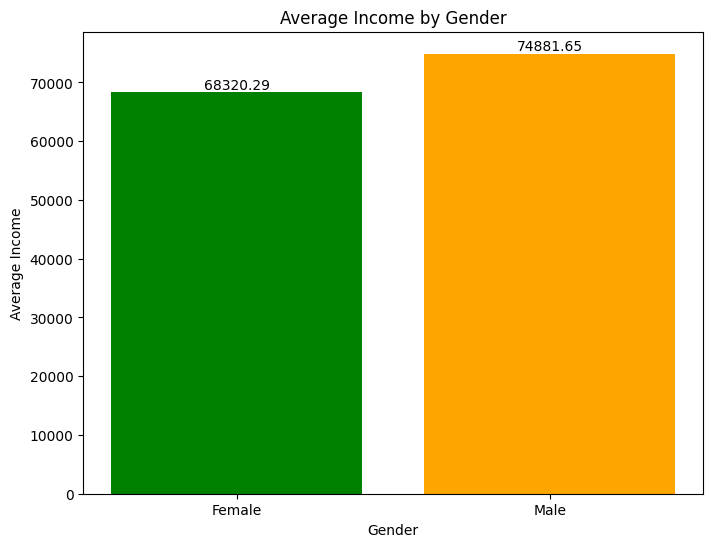

In [318]:
mean_income_by_gender = data.groupby("Gender")["Income"].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(
    mean_income_by_gender.index, mean_income_by_gender, color=["g", "orange"]
)
plt.title("Average Income by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Income")
plt.xticks(rotation=0)  # Rotate labels for readability

# Adding bar level as text above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
    )

plt.show()

我们可以看到 `Gender` 影响了平均收入。现在再次查看散点图，这次我们将使用不同颜色绘制不同性别的数据点。

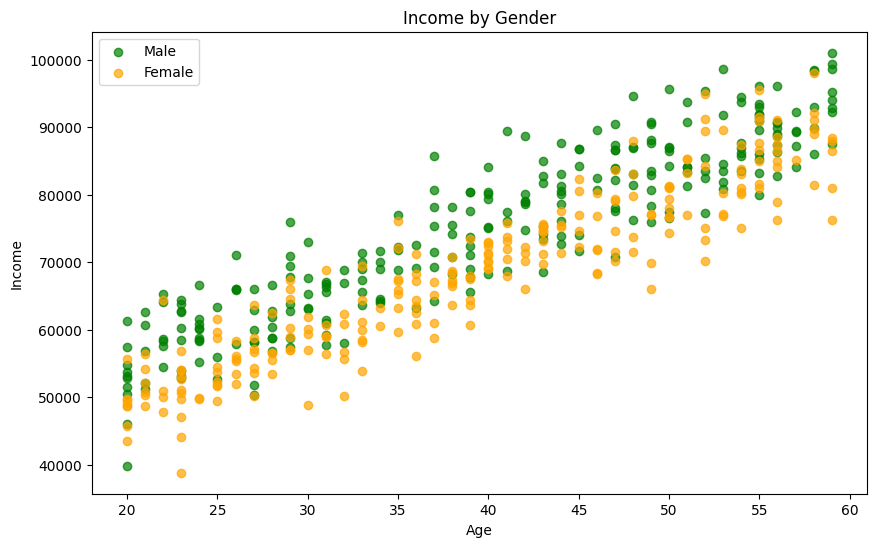

In [319]:
plt.figure(figsize=(10, 6))
colours = {"Male": "g", "Female": "orange"}
for gender in data["Gender"].unique():
    subset = data[data["Gender"] == gender]
    plt.scatter(
        subset["Age"],
        subset["Income"],
        label=f"{gender}",
        color=colours[gender],
        alpha=0.7,
    )

plt.title("Income by Gender")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend()
plt.show()

我们现在将尝试调整性别因素，并恢复 `generate_data()` 函数中使用的原始模型。首先，我们将使用 `pandas.get_dummies()` 函数将分类数据替换为二进制（$0$ 或 $1$）数据。此外，我们将使用 `drop_first` 选项，用单个变量（而不是两个）来表示 `Gender`。当值为零时表示女性，为一时表示男性。至于将哪个类别赋值为零或一并不重要，可以作为一个单独的练习来验证。

In [320]:
data_encoded = pd.get_dummies(data, columns=["Gender"], drop_first=True)
print(data_encoded.head())

   Age        Income  Gender_Male
0   20  54771.480197         True
1   23  54102.538279        False
2   23  52850.323583         True
3   59  92250.283177         True
4   29  64501.421691        False


In [321]:
x = data_encoded[["Age", "Gender_Male"]]
y = data_encoded["Income"]

x_with_intercept = add_constant(np.asarray(x, dtype=float))
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat, beta_2_hat = results.params
income_pred = results.predict(x_with_intercept)

print(rf"$\beta_2$ (Gender_Male): {beta_2_hat}")
print(rf"$\beta_1$ (Age): {beta_1_hat}")
print(f"$\beta_0$: {beta_0_hat}")

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     1537.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.54e-213
Time:                        01:21:32   Log-Likelihood:                -4958.8
No. Observations:                 500   AIC:                             9924.
Df Residuals:                     497   BIC:                             9936.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.928e+04    797.343     36.725      0.0

拟合模型为

$$
\hat y = \beta^T x = \beta_0 + \beta_1 x_{age} + \beta_2 x_{gender}
$$

其中，$\beta_0$ 表示截距，$x_{gender}$ 是一个二进制数。该模型对不同性别预测的行为如下：

$$
\hat y_{female} = \beta_0 + \beta_1 x_{age}
$$

和

$$
\hat y_{male} = (\beta_0 + \beta_2) + \beta_1 x_{age}
$$

这意味着，两个性别的收入可以通过相同的趋势（斜率）来预测，但基线有所不同。接下来我们将可视化结果。

更接近 1 的值表示模型解释了因变量方差的较大比例。然而，如果观测值较少或预测变量过多，结果可能具有误导性，此时调整后的 $R^2$ 可以提供帮助。

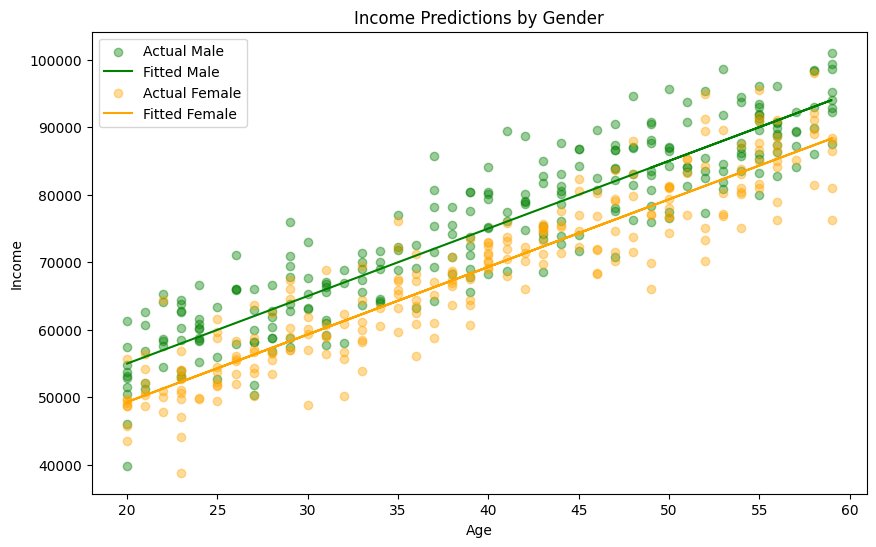

In [322]:
y_pred = results.predict(x_with_intercept)
data["Predicted_Income"] = y_pred

# Plot
plt.figure(figsize=(10, 6))
for gender in data["Gender"].unique():
    subset = data[data["Gender"] == gender]
    plt.scatter(
        subset["Age"],
        subset["Income"],
        label=f"Actual {gender}",
        color=colours[gender],
        alpha=0.4,
    )
    plt.plot(
        subset["Age"],
        subset["Predicted_Income"],
        label=f"Fitted {gender}",
        color=colours[gender],
    )

plt.title("Income Predictions by Gender")
plt.xlabel("Age")
plt.ylabel("Income")
plt.legend()  # Adding legend
plt.show()

在多维数据中，可视化预测结果的一种好方法是使用散点图，将预测值与原始结果进行比较。

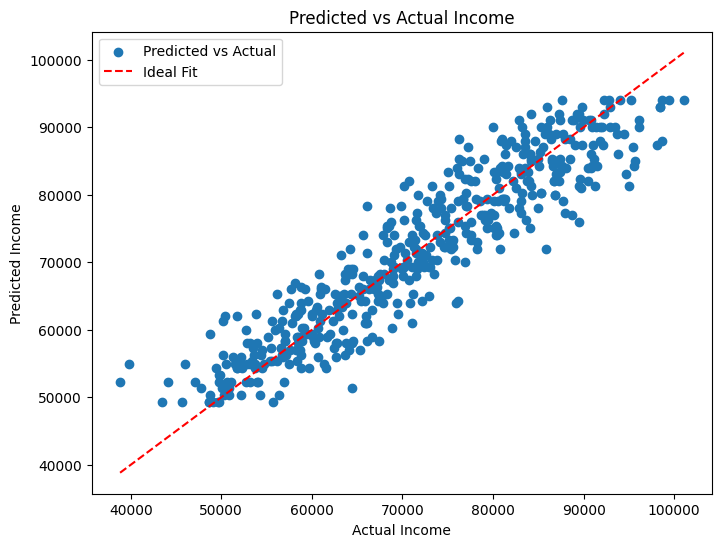

In [323]:
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label="Predicted vs Actual")
plt.plot(
    [min(y), max(y)], [min(y), max(y)], color="red", linestyle="--", label="Ideal Fit"
)  # Ideal line
plt.title("Predicted vs Actual Income")
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")
plt.legend()  # Adding legend
plt.show()

运用迄今为止学到的技能来评估模型的拟合优度，并根据零假设对其进行检验。

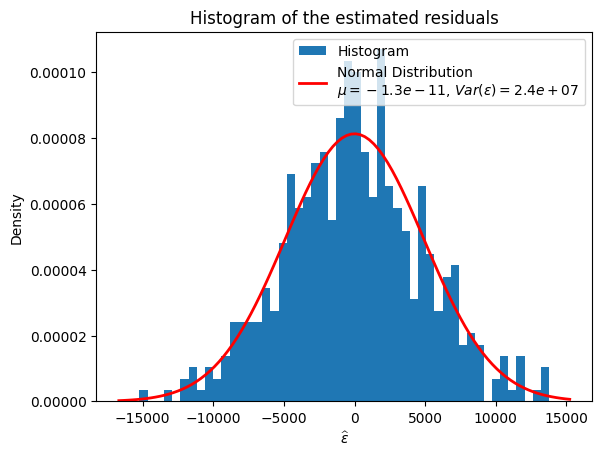

In [324]:
estimated_residuals = results.resid

plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

Shapiro-Wilk Test: 
W-statistic=0.998, 
p-value=0.861

It is a normal distribution



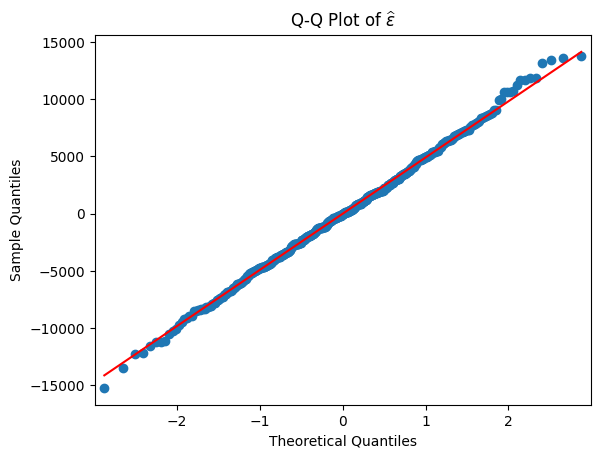

In [325]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

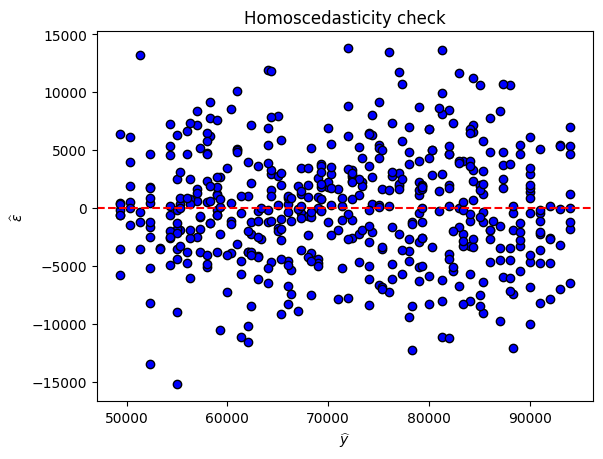

Lagrange multiplier statistic: 3.4489504084850298
p-value: 0.17826658077423202
f-value: 1.7260343668865206
f p-value: 0.17905403900907838

Homoscedasticity: The variance is constant

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     1537.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.54e-213
Time:                        01:21:33   Log-Likelihood:                -4958.8
No. Observations:                 500   AIC:                             9924.
Df Residuals:                     497   BIC:                             9936.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    st

In [326]:
plt.scatter(y_pred, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

bp_test = het_breuschpagan(estimated_residuals, x_with_intercept)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

print(results.summary())

## 多于一个类别

我们将使用另一个函数生成具有三个级别的分类。这样可以观察教育水平对个人收入的影响。

In [327]:
def generate_data_with_education(N):
    """
    Generate a DataFrame with synthetic data including education levels.

    Parameters
    ----------
    N : int
        The number of rows to generate in the DataFrame.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing `N` rows with columns for Age, Education, and Income.

    Notes
    -----
    - Education levels have 3 categories: 'High School', 'Bachelors', and 'Masters'.
    - Income is calculated as a base value plus an amount that depends on
      age and education, with some random noise added for realism.
    """
    np.random.seed(0)  # For reproducibility
    ages = np.random.randint(20, 60, size=N)
    education_levels = np.random.choice(["High School", "Bachelors", "Masters"], size=N)

    # Assign different income boost depending on education level
    education_income_boost = {"High School": 5000, "Bachelors": 10000, "Masters": 15000}
    incomes = (
        30000
        + ages * 800
        + np.array([education_income_boost[edu] for edu in education_levels])
        + np.random.normal(0, 5000, N)
    )

    df = pd.DataFrame({"Age": ages, "Education": education_levels, "Income": incomes})
    return df

创建随机的年龄和收入数据，并分配教育水平（“高中”，“学士”，“硕士”）。收入受年龄和教育的影响，较高的教育水平会带来更高的收入提升。

In [328]:
N = 500
data = generate_data_with_education(N)
print(data.head())

   Age    Education        Income
0   20      Masters  60341.128684
1   23    Bachelors  54778.450070
2   23  High School  47897.835792
3   59  High School  80390.600163
4   29    Bachelors  59592.941580


简单绘制数据图，以便可视化并选择用于行为预测的模型。

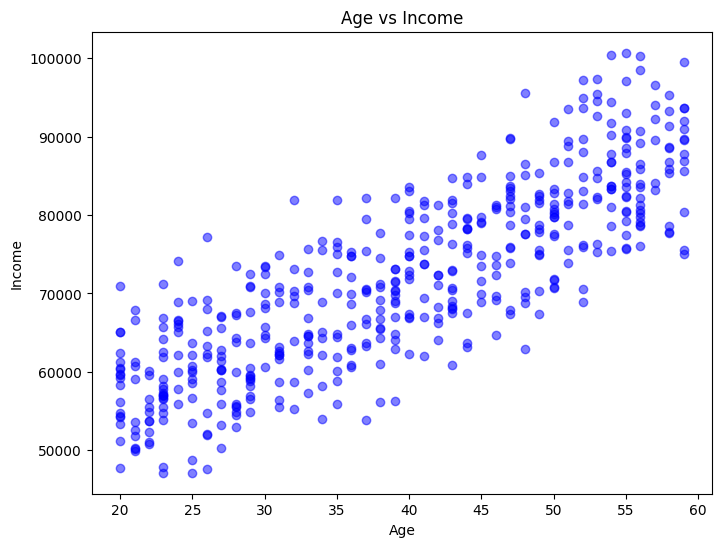

In [329]:
plt.figure(figsize=(8, 6))
plt.scatter(data["Age"], data["Income"], color="blue", alpha=0.5)
plt.title("Age vs Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

使用仅包含年龄列的简单线性回归模型来预测收入。将回归结果与实际数据点一起绘制。

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1100.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          3.42e-128
Time:                        01:21:33   Log-Likelihood:                -5103.3
No. Observations:                 500   AIC:                         1.021e+04
Df Residuals:                     498   BIC:                         1.022e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.916e+04   1028.227     38.084      0.0

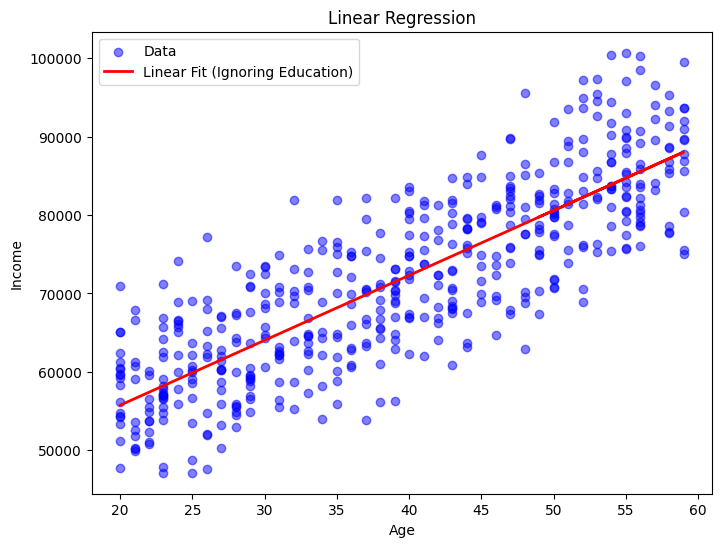

In [330]:
x = data["Age"].values.reshape(-1, 1)
y = data["Income"].values

x_with_intercept = add_constant(x)
model = OLS(y, x_with_intercept)
results = model.fit()
print(results.summary())
beta_0_hat, beta_1_hat = results.params
income_pred = results.predict(x_with_intercept)

print(rf"$\beta_1$ (Age): {beta_1_hat}")
print(f"$\beta_0$: {beta_0_hat}")

plt.figure(figsize=(8, 6))
plt.scatter(data["Age"], data["Income"], label="Data", color="blue", alpha=0.5)
plt.plot(
    data["Age"],
    income_pred,
    color="red",
    label="Linear Fit (Ignoring Education)",
    linewidth=2,
)
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Linear Regression")
plt.legend()
plt.show()

使用箱线图可视化不同教育水平下收入的分布，这有助于我们观察收入是否因教育水平而显著不同。

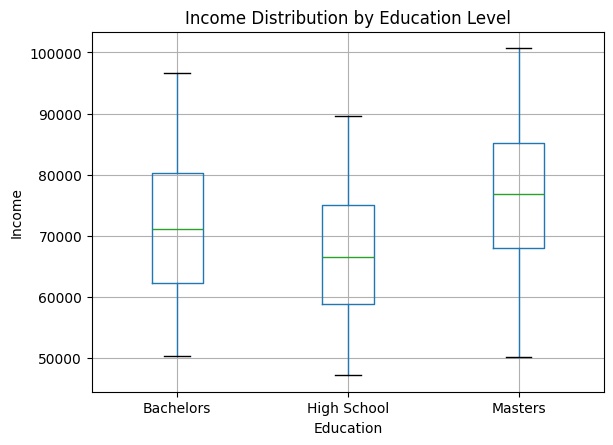

In [331]:
education_groups = ["High School", "Bachelors", "Masters"]
data.boxplot(column="Income", by="Education")
plt.title("Income Distribution by Education Level")
plt.suptitle("")  # Remove the automatic title
plt.xlabel("Education")
plt.ylabel("Income")
plt.show()

使用独热编码将分类变量“Education”列转换为二进制列（“Education_High School”和“Education_Masters”）。

In [332]:
data_encoded = pd.get_dummies(data, columns=["Education"], drop_first=True)
print(data_encoded.head())

   Age        Income  Education_High School  Education_Masters
0   20  60341.128684                  False               True
1   23  54778.450070                  False              False
2   23  47897.835792                   True              False
3   59  80390.600163                   True              False
4   29  59592.941580                  False              False


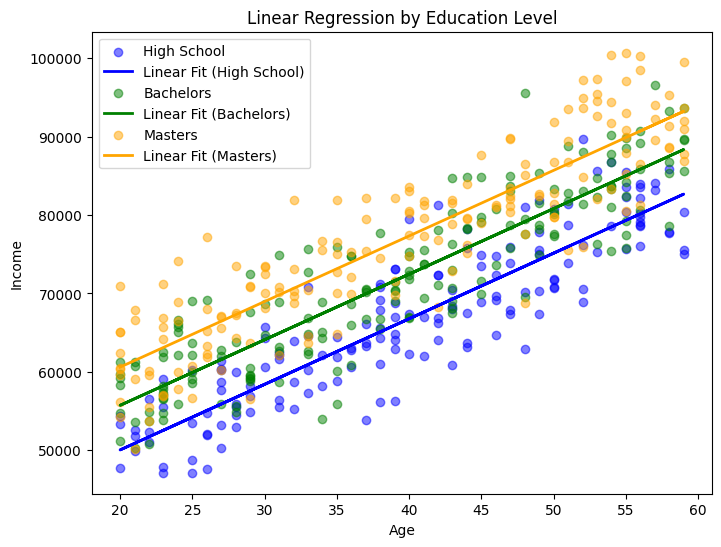

In [333]:
data_encoded = pd.get_dummies(data, columns=["Education"], drop_first=True)

X_encoded = data_encoded[["Age", "Education_High School", "Education_Masters"]]
y_encoded = data_encoded["Income"]

x_with_intercept = add_constant(np.asarray(X_encoded, dtype=float))
model_encoded = OLS(y_encoded, x_with_intercept)
results = model_encoded.fit()

y_pred_encoded = results.predict(x_with_intercept)
beta_0_hat, beta_age_hat, beta_high_school_hat, beta_masters_hat = results.params

plt.figure(figsize=(8, 6))
colors = {"High School": "blue", "Bachelors": "green", "Masters": "orange"}

for education in education_groups:
    subset = data[data["Education"] == education]
    x_subset = subset["Age"].values.reshape(-1, 1)
    y_subset = subset["Income"].values
    plt.scatter(
        subset["Age"],
        subset["Income"],
        color=colors[education],
        alpha=0.5,
        label=f"{education}",
    )

    plt.plot(
        subset["Age"],
        y_pred_encoded[data["Education"] == education],
        color=colors[education],
        label=f"Linear Fit ({education})",
        linewidth=2,
    )

plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Linear Regression by Education Level")
plt.legend()
plt.show()

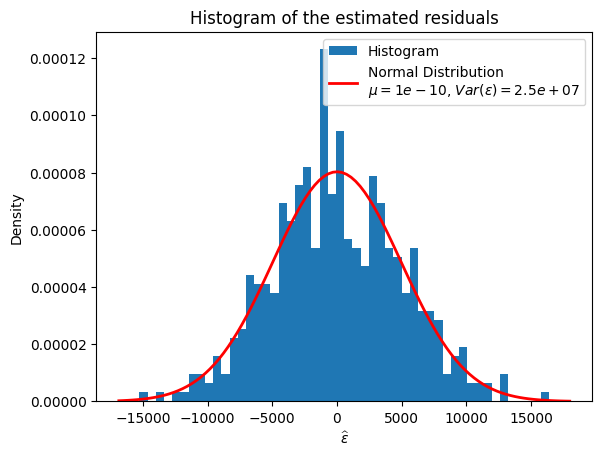

In [334]:
estimated_residuals = results.resid

plt.hist(estimated_residuals, bins=50, density=True, label="Histogram")
xmin, xmax = plt.xlim()

mean, std_dev = np.mean(estimated_residuals), np.std(estimated_residuals)
x_normal = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x_normal, mean, std_dev)

plt.plot(
    x_normal,
    p,
    "r",
    linewidth=2,
    label="Normal Distribution\n"
    rf"$\mu={mean:.2}$, $Var(\varepsilon)={np.var(estimated_residuals):.2}$",
)

plt.legend()
plt.title("Histogram of the estimated residuals")
plt.xlabel(r"$\widehat\varepsilon$")
plt.ylabel("Density")
plt.show()

Shapiro-Wilk Test: 
W-statistic=0.998, 
p-value=0.935

It is a normal distribution



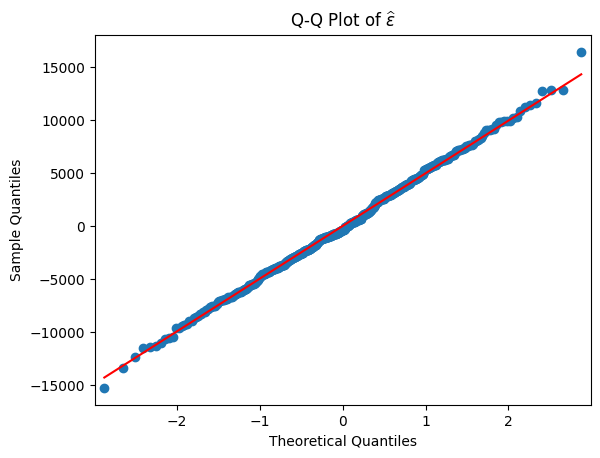

In [335]:
qqplot(estimated_residuals, line="s")
plt.title(r"Q-Q Plot of $\widehat\varepsilon$")
shapiro_test = scipy.stats.shapiro(estimated_residuals)
print(
    f"Shapiro-Wilk Test: \nW-statistic={shapiro_test.statistic:.3}, \np-value={shapiro_test.pvalue:.3}"
)
if shapiro_test.pvalue < 0.05:
    print("\nNot a normal distribution\n")
else:
    print("\nIt is a normal distribution\n")

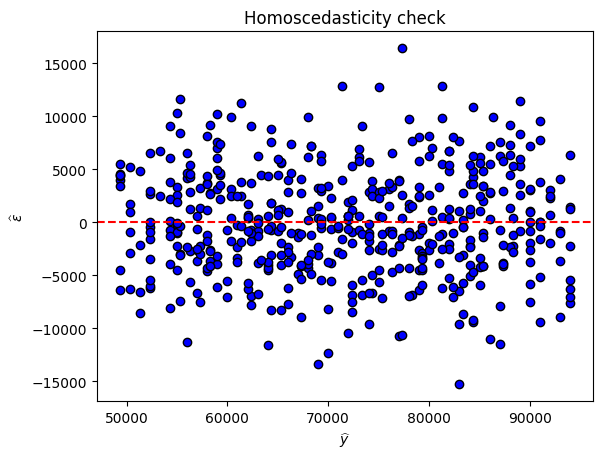

Lagrange multiplier statistic: 4.822037321561668
p-value: 0.18530198964891895
f-value: 1.610014103857147
f p-value: 0.18613087848322496

Homoscedasticity: The variance is constant

                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     757.3
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.09e-184
Time:                        01:21:34   Log-Likelihood:                -4965.0
No. Observations:                 500   AIC:                             9938.
Df Residuals:                     496   BIC:                             9955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std 

In [336]:
plt.scatter(y_pred, estimated_residuals, color="blue", edgecolor="k")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Homoscedasticity check")
plt.xlabel(r"$\widehat y$")
plt.ylabel(r"$\widehat\varepsilon$")
plt.show()

bp_test = het_breuschpagan(estimated_residuals, x_with_intercept)
labels = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_results = dict(zip(labels, bp_test))

for k, v in test_results.items():
    print(f"{k}: {v}")

if test_results["f p-value"] < 0.05:
    print("\nHeteroscedasticity: The variance is NOT constant\n")
else:
    print("\nHomoscedasticity: The variance is constant\n")

print(results.summary())